In [1]:
from __future__ import print_function

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

import cartopy.feature as cfeature
import cartopy.crs as ccrs
from pyproj import Proj, transform
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from fatiando import utils, mesher, inversion
from fatiando.gravmag import talwani

import numpy as np
import pandas as pd
import math
import os
import sys
import pickle

import shapely
from shapely.geometry import LineString, mapping
from shapely.ops import polygonize
from pprint import pprint

%matplotlib inline

C:\Users\u19955\AppData\Local\Continuum\Anaconda3\envs\maps\lib\site-packages\fatiando\vis\mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


In [2]:
# build a unique id for each CMP
def uniqueID(row):
    result = row['line_name'] + str(row['cmp'])
    return result

# clean up the line names into a nicer format
def tidylinename(row):
    result = row['line_name'].replace('-','_').replace('_cable1_gun1','')
    return result

def findIntersection(linePoints, col_name, start_position, direction, extrap_dist):   
    """
    this function linearly extends the specific horizon (column name) in the 
    specified direction ('left' or 'right') until it intersects another horizon.
    The extrapolation is done in a straight line, defined by the continuation of
    a line between the last picked point to the depth value of the horizon several
    rows back. The number of rows is provided as the extrap_dist parameter.
    The start_position parameter is the last known value, and the point that the line
    will be extrapolated from
    """    
    col_num = linePoints.columns.get_loc(col_name)
    start_value = linePoints.loc[start_position,col_name]
    intersection_found = False    
    if direction == 'left':
        step = -1
        other_value = linePoints.loc[start_position + (extrap_dist * - step),col_name]  
        limit = linePoints.index[0]       
        slope = (other_value - start_value) / extrap_dist
    else:
        step = 1
        other_value = linePoints.loc[start_position + (extrap_dist * - step),col_name]  
        limit = linePoints.index[-1]
        slope = (start_value - other_value) / extrap_dist
      
    # build a list of all columns that contain horizon data
    horCols = []
    for column in list(linePoints.columns):
        if column == 'watersurface' or column[-2:] =='_z':
            if linePoints[column].isnull().all():
                continue
            horCols.append(column) 
    
    # for each CMP beyond the edge of the current line
    for point in range(start_position, limit, step):
        next_point = point + step
        # update the next CMP along with the extrapolated value        
        linePoints.loc[next_point,col_name] = linePoints.loc[point,col_name] + (step * slope)
        # check if the horizon has crossed any of the others
        for col in horCols:
            if linePoints.columns.get_loc(col) == col_num:
                continue
            if linePoints.columns.get_loc(col) < col_num:
                if linePoints.loc[next_point,col] >= linePoints.loc[next_point,col_name]:
                    # if a shallower horizon has a depth >= extrpolated value, assign that depth
                    # to the horizon in question, record the details of the intersection
                    linePoints.loc[next_point, col_name] = linePoints.loc[next_point,col]
                    intersection_found = True
                    break
            if linePoints.columns.get_loc(col) > col_num:
                if linePoints.loc[next_point,col] <= linePoints.loc[next_point,col_name]:
                    # if a deeper horizon has a depth <= extrpolated value, assign that depth
                    # to the horizon in question, record the details of the intersection
                    linePoints.loc[next_point, col_name] = linePoints.loc[next_point,col]
                    intersection_found = True
                    break           
        if intersection_found:
            break

# use the OBS data to interpolate the moho depth along the seismic reflection lines
# assume that the crust thickness is constant along strike, so project along
# line of longitude for the interpolation
def OBSMoho(row, refract):
    if row['longitude'] > refract['long'].max():
        return 23000.0
    leftOBS = refract[refract['long'] <= row['longitude']].iloc[-1]
    rightOBS = refract[refract['long'] >= row['longitude']].iloc[0]
    longSep = rightOBS['long'] - leftOBS['long']
    longRatio = (row['longitude'] - leftOBS['long'])/longSep
    mohoSep = (rightOBS['moho_depth'] - leftOBS['moho_depth'])
    return ((leftOBS['moho_depth']) + (longRatio * mohoSep))

def customMoho(row, start_lal, end_lal, moho_change, moho_start):
    linelength = end_lal - start_lal
    prop = (row['length_along_line'] - start_lal)/ linelength
    return moho_start + (moho_change * prop)

# calculating the distance from the zero-point of each subsequent CMP
def calc_distance(row, x0, y0):
    return math.sqrt((row['x'] - x0) ** 2 + (row['y'] - y0) ** 2)

def makeLong(row):
    x = row['x']
    y = row['y']
    inProj = Proj("+proj=utm +zone=57J, +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
    outProj = Proj("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
    latlong = transform(inProj,outProj,x,y)
    return latlong[0]

def makeLat(row):
    x = row['x']
    y = row['y']
    inProj = Proj("+proj=utm +zone=57J, +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
    outProj = Proj("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs")
    latlong = transform(inProj,outProj,x,y)
    return latlong[1]

# cleaning up the line names into a nicer format
def tidylinename(row):
    result = row['line_name'].replace('-','_').replace('_cable1_gun1','')
    return result

# add start and end points beyond beyond the edge of the line
def extendCrossSection(df, line_extn_dist):
    west_extn = df.iloc[0].copy()
    west_extn['length_along_line'] = - line_extn_dist
    west_extn = pd.DataFrame(west_extn).transpose()
    east_extn = df.iloc[-1].copy()
    east_extn['length_along_line'] = east_extn['length_along_line'] + line_extn_dist
    east_extn = pd.DataFrame(east_extn).transpose()
    df = pd.concat([west_extn,df,east_extn], axis=0, ignore_index=True)
    return df

# just to check that all the horizons are correctly sorted by depth
# col_num is the first column with depth data, ie watersurface
def integrityCheck(row, col_num):
    for i in range(col_num, len(row)-1):   # len(row) - 1 because "check" column is created by now
        if np.isnan(row[i]):
            continue
        for j in range(i,len(row)-1):
            if np.isnan(row[j]):
                continue
            if row[i] > row[j]:
                return False
    return True

def talwaniCalc(shapes, densities, calc_area):
    """
    Performs the gravity forward model calculation according to
    Talwani et al.'s method as implemented by Fatiando
    
    Takes an array of polygon coordinates (as an array of [X,Y] points)
    and an array of dicts of the same length, each dict having the key
    'density', and the value of the density for the corresponding polygon
    (by index number) in kgm^-3
    """
    polys = []
    for poly in shapes:
        coords = list(poly.exterior.coords[::-1])
        coords = coords[0:-1]
        polys.append(coords)

    PolyDens = []
    for i in range(len(polys)):
        PolyDens.append(mesher.Polygon(polys[i],densities[i]))
       
    xp = np.linspace(calc_area[0], calc_area[1], num=1000) # define measurement points and compute gravity
    zp = np.zeros_like(xp)
    gz = talwani.gz(xp, zp, PolyDens)
    model = pd.DataFrame({'xp': xp, 'gz':gz})
    return model    

In [3]:
# build a list of all the horizon files (.dat) in the specified directory
# iterate through that list, importing each file as a DataFrame
# that is appended to a list of dataframes

path = 'FromDUG/'
extn = '.dat'
dug_cols =['survey', 'line_name','cmp','x','y','twt','z']
datFiles = []
horizondataframes = []

allFiles = os.listdir(path)
for f in allFiles:
    if f[-4::] == extn:
        datFiles.append(f.split('.')[0])

for f in datFiles:
    fullPath = path + f + extn
    horizondataframes.append(pd.read_csv(fullPath, delim_whitespace=True, names=dug_cols))

# combine all the data into a single dataframe
horizons = pd.concat(horizondataframes)
# drop columns not need at all or yet
horizons.drop(['survey','twt', 'z'], axis =1, inplace=True)
# remove duplicates (any CMP that had more that one horizon picked on it will be duplicated)
horizons.drop_duplicates(keep='first', inplace=True)

horizons['line_name'] = horizons.apply(lambda row: tidylinename(row), axis=1)

horizons['uid'] = horizons.apply(lambda row: uniqueID(row), axis=1)

# set unique id as index for table
horizons.set_index('uid',drop=False, inplace=True)

# iterate through the file name array as a means of naming a new column after the horizon
# for each dataframe in array, fix line name, create uniqueID as index and join onto horizons
# via index, filling the column with the depth data for that horizon
for i in range(len(datFiles)):
    horizondataframes[i]['line_name'] = horizondataframes[i].apply(lambda row: tidylinename(row), axis=1)
    horizondataframes[i]['uid'] = horizondataframes[i].apply(lambda row: uniqueID(row), axis=1)
    horizondataframes[i].set_index('uid',drop=False, inplace=True) 
    
    new_col_name = datFiles[i] + '_z'
    horizons = pd.concat([horizons, horizondataframes[i]['z'].rename(new_col_name)],
                                       axis=1, join_axes=[horizons.index])

# dropping rows with no x, y coodinates
nans = horizons['x'].isnull() | horizons['y'].isnull()
horizons.drop(horizons[nans].index, inplace=True)
horizons

,line_name,cmp,x,y,uid,EocUC_z,OligUC_z,Top_EarlySag_z,Top_PreRift_z,Top_SynRift1_z,Top_SynRift2_z,Top_Volcanics_z,Waterbottom_z
uid,,,,,,,,,,,,,
BV2A1404,BV2A,1404,667330.87,6903043.06,BV2A1404,2610.2424,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BV2A1408,BV2A,1408,667342.34,6903048.10,BV2A1408,2609.5833,NaN,2810.9458,NaN,NaN,NaN,NaN,NaN
BV2A1412,BV2A,1412,667353.81,6903053.14,BV2A1412,2608.9175,NaN,2811.8894,NaN,NaN,NaN,NaN,NaN
BV2A1416,BV2A,1416,667365.29,6903058.17,BV2A1416,2608.2670,NaN,2812.8364,NaN,NaN,NaN,NaN,NaN
BV2A1420,BV2A,1420,667376.76,6903063.21,BV2A1420,2607.6213,NaN,2813.7854,NaN,NaN,NaN,NaN,NaN
BV2A1424,BV2A,1424,667388.24,6903068.25,BV2A1424,2606.9722,NaN,2814.7388,NaN,NaN,NaN,NaN,1955.2505
BV2A1428,BV2A,1428,667399.71,6903073.28,BV2A1428,2606.3386,NaN,2815.6948,NaN,NaN,NaN,NaN,1955.7786
BV2A1432,BV2A,1432,667411.19,6903078.32,BV2A1432,2605.7092,NaN,2816.6530,NaN,NaN,NaN,NaN,1956.3787
BV2A1436,BV2A,1436,667422.66,6903083.36,BV2A1436,2605.0735,NaN,2817.6135,NaN,NaN,NaN,NaN,1956.9624


## User Action Required 4
The next cell requests user input.
Copy and paste the desired seismic line from the list provided into the text box.

In [4]:
# import the minute sampled gravity readings for each line
gravReadings = pickle.load(open('GravPerLine.pkl','rb'))

# import ocean bottom seismometer refraction data
refract_cols = ['obs_num', 'long','lat','length_along_line','waterdepth','moho_depth']
refract = pd.read_csv('OriginalData/pts_KR16-05_Gallais_OBS_moho_20170330.dat',
                      delim_whitespace=True, names=refract_cols)
refract['waterdepth'] = refract['waterdepth']*1000
refract['moho_depth'] = refract['moho_depth']*1000

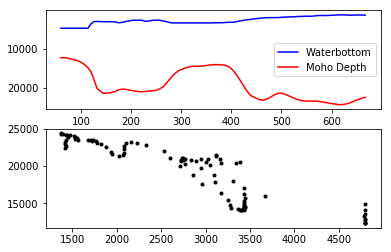

In [5]:
plt.subplot(211)
plt.plot(refract['length_along_line'], refract['waterdepth'], 'b-', label = 'Waterbottom')
plt.plot(refract['length_along_line'], refract['moho_depth'], 'r-', label = 'Moho Depth')
plt.gca().invert_yaxis()
plt.legend()
plt.subplot(212)
plt.plot(refract['waterdepth'],refract['moho_depth'], 'k.')
plt.show()

In [6]:
# using the densities backed out of the stacking velocites by Petkovic et al. 2010
water = 1010.0
passivemarginsediment = 1850.0
sag = 2130.0
syn_rift = 2310.0
sedcrust = 2440.0
crystalcrust = 2670.0
singlecrust = 2540.0
volcanics = 3000.0
mantle = 3300.0
# other densities for models

den_col_dict = {1010.0: 'cornflowerblue',
                 1850.0: 'khaki',
                 2000.0: 'yellow',
                 2130.0: 'yellow',
                 2310.0: 'gold',
                 2440.0: 'chocolate',
                 2540.0: 'hotpink',
                 2670.0: 'hotpink',
                 3000.0: 'green',
                 3300.0: 'olive'}


d3a2_den_orig = [{'density':water}, # 0
             {'density':passivemarginsediment}, # 1
             {'density':sag}, # 2
             {'density':sag}, # 3
             {'density':sag}, # 4
             {'density':syn_rift}, # 5
             {'density':syn_rift}, # 6
             {'density':sag}, # 7
             {'density':sag}, # 8
             {'density':syn_rift}, # 9
             {'density':volcanics}, # 10
             {'density':singlecrust}, # 11
             {'density':mantle}] # 12

d3a2_den_best = [{'density':water}, # 0
             {'density':passivemarginsediment}, # 1
             {'density':sag}, # 2
             {'density':sag}, # 3
             {'density':sag}, # 4
             {'density':syn_rift}, # 5
             {'density':syn_rift}, # 6
             {'density':sag}, # 7
             {'density':sag}, # 8
             {'density':syn_rift}, # 9
             {'density':volcanics}, # 10
             {'density':syn_rift}, # 11
             {'density':sedcrust}, # 12
             {'density':crystalcrust}, # 13
             {'density':mantle}] # 14

You have made 15 polygons


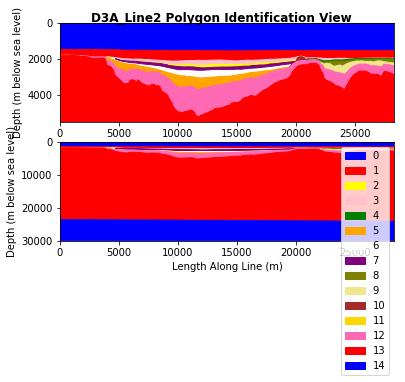

C:\Users\u19955\AppData\Local\Continuum\Anaconda3\envs\maps\lib\site-packages\fatiando\gravmag\talwani.py:90: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 1000 but corresponding boolean dimension is 1
  zvp1[zvp1[xvp1 == zvp1] == 0.] += 0.01
C:\Users\u19955\AppData\Local\Continuum\Anaconda3\envs\maps\lib\site-packages\fatiando\gravmag\talwani.py:94: RuntimeWarning: divide by zero encountered in divide
  ai = xvp1 + zvp1 * (xvp1 - xv) / (zv - zvp1)
C:\Users\u19955\AppData\Local\Continuum\Anaconda3\envs\maps\lib\site-packages\fatiando\gravmag\talwani.py:99: RuntimeWarning: invalid value encountered in multiply
  tmp = ai * sin(phi_v) * cos(phi_v) * (


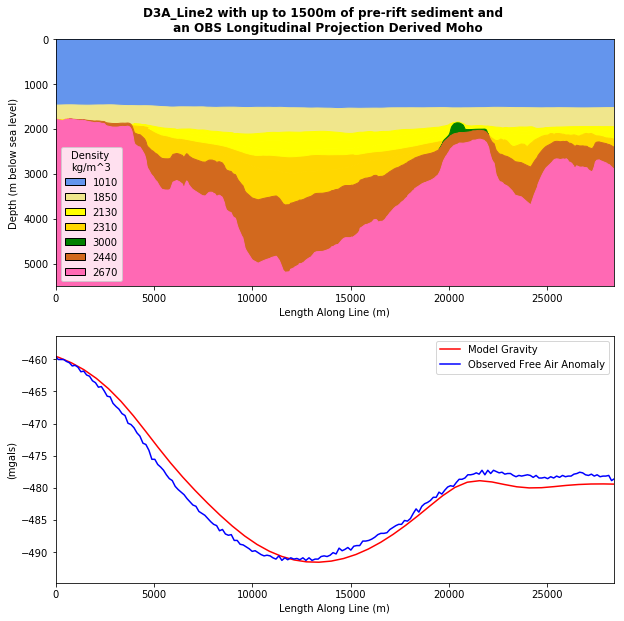

In [7]:
lineChoice = 'D3A_Line2'
densities = d3a2_den_best
colours = den_col_dict
preRiftSedDepth = 1500
depthscalefactor = 1
polyIDview = True
grav_model_view = True
moho = 'OBS'

# cutting down the data to a single seismic line
linePoints = horizons['line_name'] == lineChoice
linePoints = horizons[linePoints].copy()
gravData = gravReadings[gravReadings['line_name'] == lineChoice].copy()
gravData.reset_index(drop=True, inplace=True)

# create lat & longs for each CMP
linePoints['longitude'] = linePoints.apply(lambda row: makeLong(row), axis=1)
linePoints['latitude'] = linePoints.apply(lambda row: makeLat(row), axis=1)

# adding horizons not available from DUG
# these can be commented out if not required
linePoints['watersurface'] = 0.0
linePoints['intra_mantle_z'] = 30000.0
linePoints['moho_z'] = 23000.0

# enter the new column order as variable new_cols
# the leading 'u' before the column name should be included
new_cols = [u'line_name',
            u'cmp',
            u'uid',
            u'x',
            u'y',
            u'longitude',
            u'latitude',
            u'watersurface',
            u'Waterbottom_z',
            u'OligUC_z',
            u'EocUC_z',            
            u'Top_EarlySag_z',
            u'Top_SynRift2_z',
            u'Top_SynRift1_z',
            u'Top_Volcanics_z',
            u'Top_PreRift_z',
            u'moho_z',
            u'intra_mantle_z']
# changing the column order
linePoints = linePoints[new_cols].copy()

# calculating a horizon to be assigned as potential pre-rift sediment
# based on the assumption that the syn-rift faults were also the pre-rift faults
# so the areas with thicker syn-rift packages become the areas with thickest pre-rift sediment.
# calculated based on the depth of the CMP in question as a proportion of the maximum variation in depth
# between the highest point of the base syn-rift, and the lowest  x preRiftSedDepth variable 
preriftdeep = linePoints['Top_PreRift_z'].max()
preriftshallow = linePoints['Top_PreRift_z'].min()
preriftrange = preriftdeep - preriftshallow
if preRiftSedDepth != 0:
    new_col_index = linePoints.columns.get_loc('Top_PreRift_z') + 1
    if 'Top_Basement_z' in list(linePoints.columns):
        linePoints.drop('Top_Basement_z', inplace = True, axis = 1)
    linePoints.insert(new_col_index, 'Top_Basement_z', linePoints['Top_PreRift_z']  + preRiftSedDepth * (linePoints['Top_PreRift_z'] - preriftshallow)/preriftrange)

# sort the data points, to ensure they are in in one line from the first reading to the last
# assume that the data are:
# in a straight line
# not directly north-south (ie no repeating X/long coordinates)
# the coordinate system from DUG doesn't reset mid line (ie doesn't cross UTM zones)
linePoints.sort_values('x', axis=0, inplace=True)

# clean up CMPs where fold is decreasing and data is less good
# by simply removing this much from the start and end of the seismic line
# based on visual estimation of data quality decrease from DUG
# NOTE: the export only sends out every 4th CMP, so need to divide the number by 4
badCMP = 250
rowsToCut = int(250/4)
linePoints = linePoints.iloc[rowsToCut:-rowsToCut].copy()

# reindex the dataframe as need incremental index numbers for next operations
linePoints.reset_index(drop=True, inplace=True)

# taking the CMP location at the zero-point (based on sort order)
x0 = linePoints['x'].iloc[0]
y0 = linePoints['y'].iloc[0]
linePoints['length_along_line'] = linePoints.apply(lambda row: calc_distance(row, x0, y0), axis = 1)

# offering a range of different mohos for ease of modelling
# the default case, the OBS data is longitudionally projected on the seismic line 
if moho == 'OBS':
    mohomodel = 'n OBS Longitudinal Projection Derived Moho'
    linePoints['moho_z'] = linePoints.apply(lambda row: OBSMoho(row, refract), axis=1)
# constant user specified moho
elif isinstance(moho, (int, long, float)):
    mohomodel = ' Constant' + str(moho) + 'm deep Moho'
    linePoints['moho_z'] = moho
# assuming an Airy isostatic model, compute moho depth based on water depth
# using a linear regression of the OBS data (R2 approx 0.8)
elif moho == 'airy_interpolation':
    mohomodel = 'n Airy Isostasy based, OBS Linear Regression Moho'        
    from sklearn import linear_model
    x = refract['waterdepth'].values.reshape(len(refract['waterdepth']), 1)
    y = refract['moho_depth'].values.reshape(len(refract['moho_depth']), 1)
    mohoregress = linear_model.LinearRegression()
    mohoregress.fit(x,y)
    indata = linePoints['Waterbottom_z'].values.reshape(len(linePoints['Waterbottom_z']), 1)
    linePoints['moho_z'] = mohoregress.predict(indata)
# allow the user to specify the moho profile via a list
# if the list is only 1 number, the moho is constant
# if the list is 2 numbers, they are considered the start and end of the line, and the moho is linearly interpolated
# if the list is longer than 2, each intermediate number is considered to be an equal proportion of the way along the line
# eg 5 numbers, are considered to be the start, 1/4, 2/4, 3/4 and end of the line. Moho is again linearly interpolated
elif type(moho) == list:
    mohomodel = ' Custom Moho based on ' + str(len(moho)) + ' Points'
    # QC on the input list
    for depth in moho:
        if not isinstance(depth, (int, long, float))or depth < 0 or len(moho) == 0:  
            print('The moho depth list must contain at least 1 positive, real number')
            break
    if len(moho) == 1:
        linePoints['moho_z'] = moho[0]
    divisions = len(moho) - 1
    pieces = []
    for i in range(divisions):  
        moho_change = moho[i + 1] - moho[i]
        moho_start = moho[i]
        df_size = len(linePoints)
        span = int(df_size / divisions)
        if (i + 1) == divisions:
            df_rows = linePoints.iloc[i*span::].index
        else:
            df_rows = linePoints.iloc[i*span: (i+1)*span].index
        end_lal = linePoints.loc[df_rows]['length_along_line'].iloc[-1]
        start_lal = linePoints.loc[df_rows]['length_along_line'].iloc[0]
        pieces.append(linePoints.loc[df_rows].apply(lambda row: customMoho(row, start_lal, end_lal, moho_change, moho_start), axis = 1))
    pieces = pd.concat(pieces)
    linePoints['moho_z'] = pieces
else:
    print('Your moho is not well defined, please either enter:')
    print('a constant depth,')
    print('"OBS" to use the depths from the projection of the seismic line onto the OBS data,')
    print('"airy_interpolation" to use a moho calculated from the OBS data and local water depth calculated from a linear regression, or')
    print('a list of numbers defining points along the moho (eg [1000,1000,2000] has the left half constant, the right half sloping down.')      

# extend the model a large distance beyond the start and end of the seismic line to minimise edge effect
linePoints = extendCrossSection(linePoints, 300000)

# build a list of all columns that contain horizon data
cols = linePoints.columns
horCols = []
for col_name in cols:
    if col_name == 'watersurface' or col_name[-2:] =='_z':
        if linePoints[col_name].isnull().all():
            continue
        horCols.append(col_name)

# apply scaling factor to allow for testing of error in stacking velocity
if depthscalefactor != 1:
    for col in horCols:
        linePoints[col] = linePoints[col] * depthscalefactor

watersurface_num = linePoints.columns.get_loc('watersurface')
linePoints['check'] = linePoints.apply(lambda row: integrityCheck(row, watersurface_num), axis=1)
if (~linePoints['check']).any():
    problemLines = list(linePoints[~linePoints['check']].index)
    print("There is a a problem with the data, ie there is an older horizon above a younger one for a given CMP.\n"+
    "Check the following rows:")
    print(problemLines)
linePoints.drop('check', axis=1, inplace=True)

# figure out which columns need extending        
fullWidthHorizons = []
shortHorizons = []
for col_name in horCols:
    if (~linePoints[col_name].isnull()).all():
        fullWidthHorizons.append(col_name)
    else:
        shortHorizons.append(col_name)

# extend short horizons and fill in the gaps in horizons
for col_name in shortHorizons:
    col_num = linePoints.columns.get_loc(col_name)        
    watersurface = linePoints.columns.get_loc('watersurface') # column number of water surface

    notBlankFlags = ~linePoints[col_name].isnull()   # if cell is not NaN
    first_value = linePoints[notBlankFlags].index[0] # first non-NaN location
    last_value = linePoints[notBlankFlags].index[-1] # last non-NaN loction
    startFlags = linePoints.index >= first_value     # all the cells after the first non-NaN
    endFlags = linePoints.index <= last_value        # all the cells before the last non-NaN
    colRange = startFlags & endFlags                 # all the cells between the first and last non-NaN

    # dealing with edge cases for all short horizons
    findIntersection(linePoints, col_name, first_value, 'left', 10)
    findIntersection(linePoints, col_name, last_value, 'right', 10)
    gaps = []

    # for cases with breaks in horizons
    if not (colRange == notBlankFlags).all():
        gapPoints = ~(colRange == notBlankFlags)
        midLineGaps = linePoints[gapPoints].copy() # the cells that are gaps
        for i in list(midLineGaps.index):
            # for the start and end of each gap, record location in gaps list
            if (i-1) not in list(midLineGaps.index):
                start = i
            if (i+1) not in list(midLineGaps.index):
                end = i        
                gaps.append([start,end])

    for gap in gaps:
        start = gap[0]
        end = gap[1]
        left_edge = linePoints.loc[start - 1,col_name]       # depth value at last point left of gap
        right_edge = linePoints.loc[end + 1, col_name]       # depth value at last point right of gap
        slope = (right_edge - left_edge) / (end - start + 2) # slope across gap
        midLineGaps.loc[start,col_name] = linePoints.loc[start - 1, col_name] + slope

        for i in range(start+1, end + 1, 1):
            # linearly interpolated gap filling
            midLineGaps.loc[i,col_name] = midLineGaps.loc[i - 1, col_name] + slope
        # if midLineGaps fails integrity check (ie another horizon crosses the one in question)
#         if len(midLineGaps[~midLineGaps.apply(lambda row: integrityCheck(row, watersurface), axis = 1)]) > 0:
#         if (~(midLineGaps.apply(lambda row: integrityCheck(row, watersurface_num), axis = 1))).any():
        if (~((midLineGaps.loc[start:end]).apply(lambda row: integrityCheck(row, watersurface_num), axis = 1))).any():
                # extend horizons into gap to intersecting horizon
                findIntersection(linePoints, col_name, end+1, 'left', 10)
                findIntersection(linePoints, col_name, start-1, 'right', 10)            
        else:
            # fill the horizon with a linear interpolation
            for i in range(start, end + 1, 1):
                linePoints.loc[i,col_name] = linePoints.loc[i - 1, col_name] + slope

# find all intersections and line ends
intersections = []
segments = []
segmentNames = []
Xmin = linePoints['length_along_line'].min()
Xmax = linePoints['length_along_line'].max()

# for each column, iterate through and find intersections
for col_name in horCols:
    col_num = linePoints.columns.get_loc(col_name)
    first_col = linePoints.columns.get_loc(horCols[0])
    last_col = linePoints.columns.get_loc(horCols[-1])
    segment = []
    # for each row in each column
    for row in linePoints.index:    
        isSegmentEnd = False
        x = linePoints.loc[row,'length_along_line']
        z = linePoints.loc[row,col_name]        
        # if no value in cell, go to next row
        if np.isnan(z):
            continue           
        # if row is left edge of cross-section, start new segment, record as intersection
        if x == Xmin:
            intersections.append((x, z))               
        # if row is left edge of cross section, record as intersection, flag as segment end
        if x == Xmax:
            intersections.append((x, z))
            isSegmentEnd = True
        for lower_col_num in range(first_col,last_col + 1):
            if lower_col_num == col_num:
                continue
            lower_col_name = linePoints.columns[lower_col_num]
            if (not np.isnan(z) and 
                not np.isnan(linePoints.loc[row,lower_col_name]) and 
                z == linePoints.loc[row,lower_col_name]):
                intersections.append((x, z))
                isSegmentEnd = True
                break
        if len(segment) == 0:
            isSegmentEnd = False
        if isSegmentEnd:
            segment.append((x, z))
            segments.append(segment)
            segmentNames.append(col_name + str(row))
            segment = []
            if row + 1 in linePoints.index and not np.isnan(linePoints.loc[row+1,col_name]):
                segment.append((x, z))
        if not isSegmentEnd:
            segment.append((x, z))    

# building left vertical segments
for col_name in horCols:
    segment = []
    col_num = linePoints.columns.get_loc(col_name)
    LAL = linePoints.columns.get_loc('length_along_line')
    end_col_num = linePoints.columns.get_loc(horCols[-1])
    x = linePoints.iloc[0,LAL]
    z = linePoints.iloc[0,col_num]    
    if col_name == horCols[-1]:
        break
    if np.isnan(z):
        continue
    segment.append((x, z))
    for next_col_num in range(col_num + 1,end_col_num + 1):
        z1 = linePoints.iloc[0,next_col_num]
        if np.isnan(z1):
            continue
        segment.append((x, z1))
        break
    segments.append(segment)
    segmentNames.append('left_vert_' + col_name + '_down')

# building right vertical segments
for col_name in horCols:
    segment = []
    col_num = linePoints.columns.get_loc(col_name)
    LAL = linePoints.columns.get_loc('length_along_line')
    end_col_num = linePoints.columns.get_loc(horCols[-1])
    x = linePoints.iloc[-1,LAL]
    z = linePoints.iloc[-1,col_num]    
    if col_name == horCols[-1]:
        break
    if np.isnan(z):
        continue
    segment.append((x, z))
    for next_col_num in range(col_num + 1,end_col_num + 1):
        z1 = linePoints.iloc[-1,next_col_num]
        if np.isnan(z1):
            continue
        segment.append((x, z1))
        break
    segments.append(segment)
    segmentNames.append('right_vert_' + col_name + '_down')

shapelysegs = []
for seg in segments:
    shapelysegs.append(LineString(seg))
shapelypolys = list(polygonize(shapelysegs))
shapelycentroids = []
for poly in shapelypolys:
    shapelycentroids.append(poly.centroid)
shapelyreppoints = []
for poly in shapelypolys:
    shapelyreppoints.append(poly.representative_point())

print('You have made ' + str(len(shapelypolys)) + ' polygons')

# pulling out the max and min values of the bounds of the data
allCoords = []
for poly in shapelypolys:
    coords = list(poly.exterior.coords)
    for point in coords:
        allCoords.append(point)
arr = np.array(allCoords)
Xmin = np.nanmin(arr[:,0])
XminDisplay = 0
line_extn = abs(Xmin - XminDisplay)
Xmax = np.nanmax(arr[:,0])
XmaxDisplay = Xmax - line_extn
Zmin = 0
ZminDisplay = 0
Zmax = np.nanmax(arr[:,1])
ZmaxDisplay = 5500

calc_area = [Xmin, Xmax, Zmin, Zmax]
draw_area = [XminDisplay, XmaxDisplay, ZminDisplay, ZmaxDisplay]
imagepath = 'FinalImages/'

if polyIDview:
    title = (lineChoice + ' Polygon Identification View')
    plt.suptitle(title, fontsize=12, fontweight='demibold', position = (0.5, .92))
    fig_size = [10,10] 
    font = {'size':25}
    mycolours = ['blue', 'red', 'yellow', 'pink', 'green', 'orange', 'white',
                 'purple', 'olive', 'khaki', 'brown', 'gold', 'hotpink',
                 'red', 'blue', 'yellow', 'pink', 'green', 'orange', 'white',
                 'purple', 'olive', 'khaki', 'brown', 'gold', 'hotpink']
    plt.subplot(211)
    plt.axis(draw_area)
    for i in range(len(shapelypolys)): 
        poly = Polygon(list(shapelypolys[i].exterior.coords), closed = True,
                       color = mycolours[i], label = str(i))
        plt.gca().add_patch(poly)
    plt.gca().invert_yaxis()
    plt.xlabel('Length Along Line (m)')
    plt.ylabel('Depth (m below sea level)')

    plt.subplot(212)
    plt.axis([draw_area[0],draw_area[1],calc_area[2], calc_area[3]])
    for i in range(len(shapelypolys)): 
        poly = Polygon(list(shapelypolys[i].exterior.coords), closed = True,
                       color = mycolours[i], label = str(i))
        plt.gca().add_patch(poly)
    plt.gca().invert_yaxis()
    plt.xlabel('Length Along Line (m)')
    plt.ylabel('Depth (m below sea level)') 
    plt.legend(title='Polygon Number')
    plt.legend()
#         plt.tight_layout()
    plt.rcParams["figure.figsize"] = fig_size
    imagepath = 'FinalImages/'
    plt.savefig(imagepath + lineChoice + '_PRsed' + str(preRiftSedDepth) + '_polyIDview' + '.svg')
    plt.savefig(imagepath + lineChoice + '_PRsed' + str(preRiftSedDepth) + '_polyIDview' + '.png')
    plt.show()


if grav_model_view:
    # running the gravity model
    model = talwaniCalc(shapelypolys, densities, calc_area)

    modelX = linePoints[linePoints['length_along_line'] == 0].iloc[0,linePoints.columns.get_loc('x')]
    modelY = linePoints[linePoints['length_along_line'] == 0].iloc[0,linePoints.columns.get_loc('y')]
    measureX = gravData.loc[0,'x']
    measureY = gravData.loc[0,'y']
    offset = math.sqrt((modelX - measureX)**2 + (modelY - measureY)**2)
    if modelX > measureX:
        offset *= -1
    model['x_shifted'] = model['xp'] + offset
    gravReadingToUse = 'raw_free_air_anom_mgals'
    gravToPlot = 'grav_for_plotting'
    gravData[gravToPlot] = gravData[gravReadingToUse] + gravData['drift_correction_mgals']
    if model[model['x_shifted'] >= 0].reset_index(drop = True).iloc[0,model.columns.get_loc('gz')] == 0:
        zeropoint_gz = model[model['x_shifted'] >= 0].reset_index(drop = True).iloc[0,model.columns.get_loc('gz')]
    else:
        first_pos_g = model[model['x_shifted'] >= 0].reset_index(drop = True).iloc[0,model.columns.get_loc('gz')]
        last_neg_g = model[model['x_shifted'] < 0].reset_index(drop = True).iloc[-1,model.columns.get_loc('gz')]
        first_pos_x = model[model['x_shifted'] >= 0].reset_index(drop = True).iloc[0,model.columns.get_loc('x_shifted')]
        last_neg_x = model[model['x_shifted'] < 0].reset_index(drop = True).iloc[-1,model.columns.get_loc('x_shifted')]
        x_range = first_pos_x - last_neg_x
        g_range = first_pos_g - last_neg_g
        zeropoint_gz = last_neg_g + g_range * (abs(last_neg_x)/x_range)
    model['g_shifted'] = (model['gz'] - zeropoint_gz + gravData.iloc[0,gravData.columns.get_loc(gravToPlot)])

    Xmin = draw_area[0]
    Xmax = draw_area[1]
    ModelViewRange = model[(Xmin <= model['xp']) & (Xmax >= model['xp'])]
    modelMax = ModelViewRange['g_shifted'].max()
    modelMin = ModelViewRange['g_shifted'].min()
    dataViewRange = gravData[(draw_area[0] <= gravData['length_along_line_m'])
                             & (draw_area[1] >= gravData['length_along_line_m'])]
    gravMax = dataViewRange[gravToPlot].max()
    gravMin = dataViewRange[gravToPlot].min()
    axisEdge = (max(gravMax,modelMax) - min(gravMin,modelMin))/10
    gravAxis = [min(gravMin,modelMin) - axisEdge, max(gravMax,modelMax) + axisEdge]

    # draw seismic based cross-section
    fig_size = [10,10] 
    font = {'size':25}
    title = (lineChoice + ' with up to ' + str(preRiftSedDepth)
             + 'm of pre-rift sediment and \n a'+ mohomodel)
    plt.subplot(211)
    plt.suptitle(title, fontsize=12, fontweight='demibold', position = (0.5, .925))
    plt.axis(draw_area)
    legendpatches = []
    inlegend = []
    for i in range(len(shapelypolys)):
        poly = Polygon(list(shapelypolys[i].exterior.coords), closed = True,
                       color = den_col_dict[densities[i]['density']])
        plt.gca().add_patch(poly)
        shallowpoint = np.array(shapelypolys[i].exterior.xy)[1].min()
        if (shallowpoint < draw_area[3]) and (densities[i]['density'] not in inlegend):
            inlegend.append(densities[i]['density'])
            legendpatches.append(mpatches.Patch(facecolor = den_col_dict[densities[i]['density']],
                                                edgecolor='black',
                                                label = str(int(densities[i]['density']))))
    plt.gca().invert_yaxis()
    plt.xlabel('Length Along Line (m)')
    # plt.gca().get_xaxis().set_visible(False)
    plt.ylabel('Depth (m below sea level)')
    legtitle = 'kg/m^3'
    plt.legend(handles=legendpatches, title='Density\n' + legtitle)

    # draw line charts to compare model and actual gravity
    plt.subplot(212)
    plt.plot(model['x_shifted'], model['g_shifted'], 'r-', label ='Model Gravity')
    plt.plot(gravData['length_along_line_m'], gravData[gravToPlot],'b-', label='Observed Free Air Anomaly')
    plt.ylabel('(mgals)')
    plt.xlabel('Length Along Line (m)')
    plt.xlim(draw_area[0],draw_area[1])
    plt.ylim(gravAxis)
    plt.legend()
    plt.rcParams["figure.figsize"] = fig_size
    plt.savefig(imagepath + lineChoice + '_PRsed' + str(preRiftSedDepth) + '_' + str(moho) + '_modelview' + '.svg')
    plt.savefig(imagepath + lineChoice + '_PRsed' + str(preRiftSedDepth) + '_modelview' + '.png')
    plt.show()

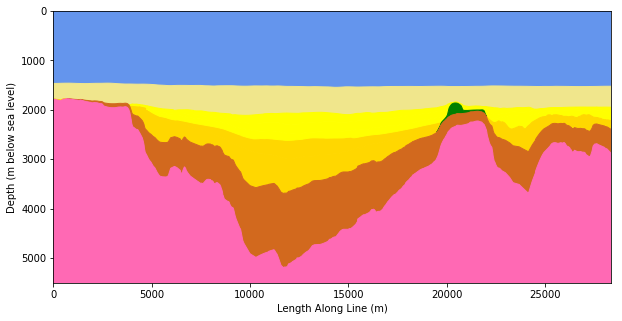

In [93]:
# blank cross-section for markup in powerpoint

fig_size = [10,5] 
plt.rcParams["figure.figsize"] = fig_size
font = {'size':25}
plt.subplot(111)
plt.axis(draw_area)
legendpatches = []
inlegend = []
for i in range(len(shapelypolys)):
    poly = Polygon(list(shapelypolys[i].exterior.coords), closed = True,
                   color = den_col_dict[densities[i]['density']])
    plt.gca().add_patch(poly)
    shallowpoint = np.array(shapelypolys[i].exterior.xy)[1].min()
    if (shallowpoint < draw_area[3]) and (densities[i]['density'] not in inlegend):
        inlegend.append(densities[i]['density'])
        legendpatches.append(mpatches.Patch(facecolor = den_col_dict[densities[i]['density']],
                                            edgecolor='black'))
plt.gca().invert_yaxis()
plt.xlabel('Length Along Line (m)')
plt.ylabel('Depth (m below sea level)')
plt.savefig(imagepath + 'prerift_sed_explanation.svg')
plt.savefig(imagepath + 'prerift_sed_explanation.png')
plt.show()

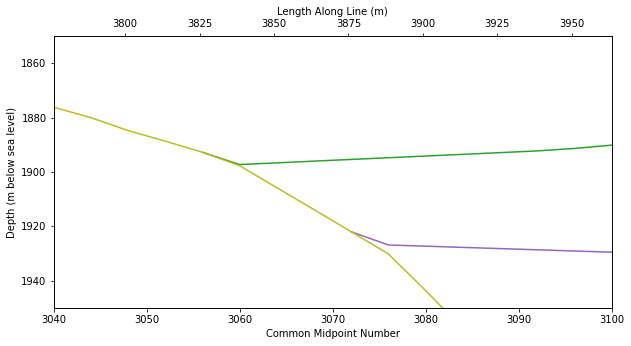

In [87]:
fig_size = [10,5] 
plt.rcParams["figure.figsize"] = fig_size

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

ax1.axis([3040,3100,1850,1950])
for hor in horCols:
    ax1.plot(linePoints['cmp'], linePoints[hor])
ax1.invert_yaxis()

cmp_range = ax1.get_xlim()
cmp_min = cmp_range[0]
cmp_max = cmp_range[1]
lal_min = float(linePoints[linePoints['cmp'] == cmp_min]['length_along_line'].values)
lal_max = float(linePoints[linePoints['cmp'] == cmp_max]['length_along_line'].values)
ax2.set_xlim([lal_min, lal_max])

ax1.set_xlabel('Common Midpoint Number')
ax1.set_ylabel('Depth (m below sea level)')
ax2.set_xlabel('Length Along Line (m)')
fig.savefig(imagepath + 'stepexample.svg')
fig.savefig(imagepath + 'stepexample.png')
fig.show()

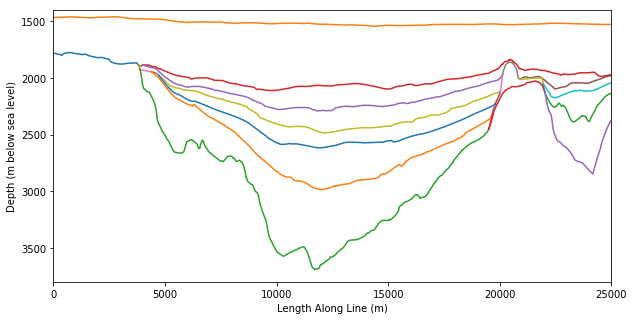

In [86]:
fig_size = [10,5] 
plt.rcParams["figure.figsize"] = fig_size
plt.subplot(111)
plt.axis([0,25000,1400,3800])
for seg in shapelysegs:
    arr = np.array(seg.coords)
    plt.plot(arr[:,0], arr[:,1])
plt.gca().invert_yaxis()
plt.xlabel('Length Along Line (m)')
plt.ylabel('Depth (m below sea level)')
plt.savefig(imagepath + 'colouredsegments.svg')
plt.savefig(imagepath + 'colouredsegments.png')
plt.show()

In [94]:
print(linePoints['Top_PreRift_z'].max(), linePoints['Top_PreRift_z'].min())


3691.5613 1775.1499
